In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import os

In [2]:
class Classifier(object):
    def __init__(self, scikit_classifier_name, **classifier_args):
        classifer_class = get_class(scikit_classifier_name)
        self.clf = classifer_class(**classifier_args)

def get_class(kls):
    parts = kls.split('.')
    module = ".".join(parts[:-1])
    md = __import__(module)
    for comp in parts[1:]:
        md = getattr(md, comp)
    return md

In [27]:
class Aggregator(object):
    def __init__(self, domain_labels):
        self.domain_labels = domain_labels  # list of labels in the domain

    def aggregate(self, graph, node, conditional_node_to_label_map):
        raise NotImplementedError

class Count(Aggregator):
    def aggregate(self, graph, node, conditional_node_to_label_map):
        neighbor_undirected = []
        for x in self.domain_labels:
            neighbor_undirected.append(0.0)
        for i in G.adj[node].keys():
            if i in conditional_node_to_label_map.keys():
                index = self.domain_labels.searchsorted(conditional_node_to_label_map[i])
                print(i, conditional_node_to_label_map[i])
                print(index) ############### FIXME
                neighbor_undirected[index] += 1.0
        return neighbor_undirected
    
def create_map(Y, train_indices):
    conditional_map = {}
    for i in train_indices:
        conditional_map[i] = Y[i]
    return conditional_map

In [33]:
class RelationalClassifier(Classifier):
    def __init__(self, scikit_classifier_name, aggregator, **classifier_args):
        super(RelationalClassifier, self).__init__(scikit_classifier_name, **classifier_args)
        self.aggregator = aggregator

    def fit(self, graph, X, Y, train_indices, local_classifier, bootstrap):
        conditional_map = {}

        if bootstrap:
            predictclf = local_classifier.predict(X)
            conditional_map = self.cond_mp_upd(graph, conditional_map, predictclf, list(range(graph.number_of_nodes())))

        for i in train_indices:
            conditional_map[i] = Y.loc[i]
        aggregates = []
        for i in train_indices:
            aggregates.append(sp.csr_matrix(self.aggregator.aggregate(graph, i, conditional_map), dtype=np.float64))
        features = X.loc[train_indices]
        labels = Y.loc[train_indices]
        features = sp.csr_matrix(features, dtype=np.float64)
        aggregates = sp.vstack(aggregates)
        features = sp.hstack([features, aggregates])
        #np.column_stack([X,a])
        self.clf.fit(features, labels)

    def predict(self, graph, X, Y, test_indices, conditional_map=None):
        aggregates = []
        for i in test_indices:
            aggregates.append(sp.csr_matrix(self.aggregator.aggregate(graph, i, conditional_map), dtype=np.float64))
        features = X.loc[test_indices]
        features = sp.csr_matrix(features, dtype=np.float64)
        aggregates = sp.vstack(aggregates)
        features = sp.hstack([features, aggregates])

        return self.clf.predict(features)

    def cond_mp_upd(self, graph, conditional_map, pred, indices):
        for x in range(len(pred)):
            conditional_map[indices[x]] = pred[x]
        return conditional_map

In [5]:
class ICA(Classifier):
    def __init__(self, local_classifier, relational_classifier, bootstrap, max_iteration=10):
        self.local_classifier = local_classifier
        self.relational_classifier = relational_classifier
        self.bootstrap = bootstrap
        self.max_iteration = max_iteration

    def fit(self, graph, X, Y, train_indices):
        self.local_classifier.fit(X.loc[train_indices], Y.loc[train_indices])
        self.relational_classifier.fit(graph, X, Y, train_indices, self.local_classifier, self.bootstrap)

    def predict(self, graph, X, Y, eval_indices, test_indices, conditional_node_to_label_map=None):
        predictclf = self.local_classifier.predict(X.loc[eval_indices])
        conditional_node_to_label_map = self.cond_mp_upd(graph,
                                                         conditional_node_to_label_map,
                                                         predictclf, eval_indices)

        relation_predict = []
        temp = []
        for iter in range(self.max_iteration):
            for x in eval_indices:
                temp.append(x)
                rltn_pred = list(self.relational_classifier.predict(graph, X, Y, temp, conditional_node_to_label_map))
                conditional_node_to_label_map = self.cond_mp_upd(graph, conditional_node_to_label_map, rltn_pred, temp)
                temp.remove(x)
        for ti in test_indices:
            relation_predict.append(conditional_node_to_label_map[ti])
        return relation_predict

    def cond_mp_upd(self, graph, conditional_map, pred, indices):
        for x in range(len(pred)):
            conditional_map[indices[x]] = pred[x]
        return conditional_map

# Test on synthetic dataset

In [6]:
from sklearn.datasets import make_blobs
X, Y = make_blobs(n_samples=1000, centers=20, random_state=123)
labels = [0, 1]
Y = np.take(labels, (Y < 10))
print(X) 
print(Y[:5])

[[-6.45255647 -8.76358259]
 [ 0.28982141  0.14677196]
 [-5.18412293 -1.25347025]
 ...
 [-0.23142814 -1.60800704]
 [-0.60291835  6.87297279]
 [ 2.28425964  4.87408773]]
[1 1 0 1 0]


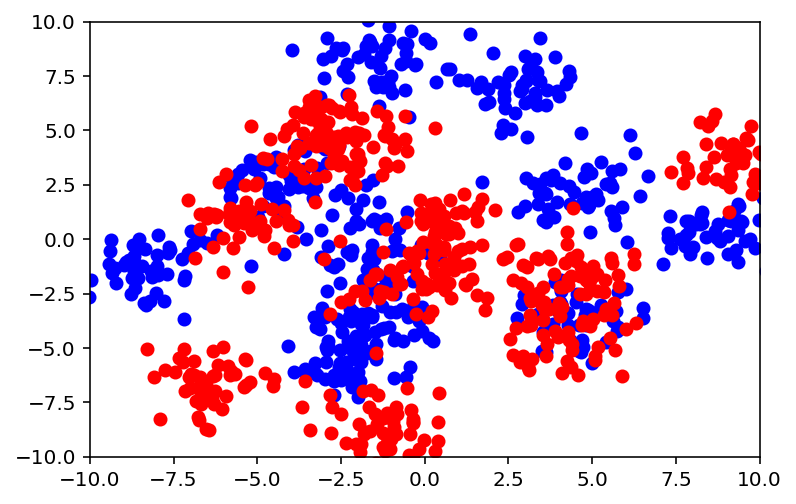

In [7]:
plt.figure()
colors=['b','r']
for label in labels:
    mask = (Y == label)
    plt.scatter(X[mask, 0], X[mask, 1], c=colors[label])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

In [8]:
G = nx.gnm_random_graph(1000, 10000)
#nx.draw(G, with_labels=False)

In [9]:
def aggregateFittedValues(Y_hat, G, fun=np.mean, idx_update=None):
    '''Returns an aggregation of the predicted labels in a 1-hop neighborhood of G'''
    agg = np.empty((Y_hat.shape[0], fun(Y_hat[0]).shape[0]))
    #agg = np.empty(Y_hat.shape[0])
    for n,nbrs in G.adj.items():
        if not idx_update:
            agg[n] = fun(Y_hat[list(nbrs.keys())])
        else:
            if n in idx_update:
                agg[n] = fun(Y_hat[list(nbrs.keys())])
            else:
                agg[n] = fun(Y_hat[n])
                
    return agg

# Reproduce results on Cora dataset

In [10]:
# %load utils.py
"""" This implementation is largely based on and adapted from:
 https://github.com/sskhandle/Iterative-Classification """
import networkx as nx
import pickle as pkl
import numpy as np
import scipy.sparse as sp
import os.path

def build_labels(labels):
    domain_labels = []
    for i in range(labels.shape[1]):
        domain_labels.append("c" + str(i))

    return domain_labels

def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

def load_data(dataset_str):
    """Load data."""
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        objects.append(pkl.load(open("data/ind.{}.{}".format(dataset_str, names[i]), 'rb'), encoding='latin1'))
    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("data/ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset_str == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = list(range(min(test_idx_reorder), max(test_idx_reorder) + 1))
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range - min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1] - 1))
        ty_extended_ = np.ones((len(test_idx_range_full), 1))  # add dummy labels
        ty_extended = np.hstack([ty_extended, ty_extended_])
        ty_extended[test_idx_range - min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    idx_test = test_idx_range.tolist()
    idx_train = list(range(len(y)))
    idx_val = list(range(len(y), len(y) + 500))

    return adj, features, labels, idx_train, idx_val, idx_test


In [11]:
adj, features, labels, idx_train, idx_val, idx_test = load_data('cora')
domain_labels = build_labels(labels)
idx_eval = np.setdiff1d(list(range(adj.shape[0])), idx_train)
domain_labels = np.array(domain_labels)
domain_labels

array(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6'], dtype='<U2')

In [12]:
print(len(idx_train), len(idx_val), len(idx_test))
print(adj.shape, adj.nnz//2, features.shape, len(labels))

140 500 1000
(2708, 2708) 5278 (2708, 1433) 2708


In [13]:
features.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [14]:
labels[0]==1

array([False, False, False,  True, False, False, False])

In [15]:
labels.shape[0]

2708

In [16]:
X = features.toarray()
#Y = labels[:,3]
Y = np.apply_along_axis(lambda x: domain_labels[x==1], 1, labels).ravel()
G = nx.Graph(adj)

In [19]:
print(X.shape, Y.shape)
labels.sum(axis=0)

(2708, 1433) (2708,)


array([351, 217, 418, 818, 426, 298, 180])

In [20]:
np.zeros_like(domain_labels, dtype='float')

array([0., 0., 0., 0., 0., 0., 0.])

In [21]:
def count_aggregate(neighbors_labels, domain_labels):
    result = np.zeros_like(domain_labels, dtype='float')
    for lbl in np.nditer(neighbors_labels):
        index = domain_labels.searchsorted(lbl)
        result[index] += 1.0
    return result

In [22]:
Xdf = pd.DataFrame(X)
Ydf = pd.DataFrame(Y)
print(Xdf.head(), Ydf.head())

   0     1     2     3     4     5     6     7     8     9     ...   1423  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
4   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   

   1424  1425  1426  1427  1428  1429  1430  1431  1432  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 1433 columns]     0
0  c3
1  c4
2  c4
3  c0
4  c3


In [23]:
max_iter = 10

lclsf = LogisticRegression()
lclsf.fit(Xdf.loc[idx_train,:],Ydf.loc[idx_train].values.ravel())
print(lclsf.C, lclsf.coef_.shape)
#Y_pred = lclsf.predict(X[idx_test,:])
#print(sklearn.metrics.accuracy_score(y_true=Y[idx_test], y_pred=Y_pred))

X_prime = X
for i in range(max_iter):
    lclsf.fit(X_prime[idx_train,:], Y[idx_train])
    Y_pred = lclsf.predict(X_prime)
    print(sklearn.metrics.accuracy_score(y_true=Y[idx_test], y_pred=Y_pred[idx_test]))
    Y_hat = lclsf.predict(X_prime) # bootstrap
    Y_hat[idx_train] = Y[idx_train]
    a = aggregateFittedValues(Y_hat, G, fun=lambda x: count_aggregate(x, domain_labels=domain_labels),
                              idx_update=set(idx_train))
    #Y_hat = lclsf.predict_proba(X_prime)
    #a = aggregateFittedValues(Y_hat, G)
    X_prime = np.column_stack([X,a])

print(lclsf.C, lclsf.coef_.shape) 

1.0 (7, 1433)
0.589
0.587
0.587
0.587
0.587
0.587
0.587
0.587
0.587
0.587
1.0 (7, 1440)


In [24]:
set(G.adj[10].keys())

{476, 2545}

In [25]:
c = Count(domain_labels)
c.aggregate(G, 10, {476:'c0', 2545:'c5'})

c0
0
c5
5


[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]

# Main

In [34]:
cmap = create_map(Y, idx_train)
locclsf = LogisticRegression()
locclsf.fit(Xdf.loc[idx_train], Ydf.loc[idx_train].values.ravel())
relclsf = RelationalClassifier('sklearn.linear_model.LogisticRegression', Count(domain_labels))
relclsf.fit(G, Xdf, Ydf, idx_train, locclsf, bootstrap=True)
rel_pred = relclsf.predict(G, Xdf, Ydf, idx_test, cmap)
accuracy_score(y_true=Y[idx_test], y_pred=rel_pred)

633 c3
3
1862 c3
3
2582 c6
6
2 0    c4
Name: 2, dtype: object
[4]


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
ica = ICA(locclsf, relclsf, bootstrap=True)
ica.fit(G, Xdf, Ydf, idx_train)
cmap = create_map(Ydf, idx_train)
ica_predict = ica.predict(G, Xdf, Ydf, idx_eval, idx_test, cmap)


In [ ]:
ica_accuracy = accuracy_score(Ydf.loc[idx_test], ica_predict)
ica_accuracy

In [ ]:
pd.DataFrame(np.matrix(relclsf.clf.coef_[:,1433:1440]))

In [ ]:
cmap = create_map(Ydf, idx_test)
locclsf = LogisticRegression()
locclsf.fit(X[idx_test], Ydf.loc[idx_test])
accuracy_score(y_true=Ydf.loc[idx_train], y_pred=locclsf.predict(Xdf.loc[idx_train]))

In [ ]:
relclsf = RelationalClassifier('sklearn.linear_model.LogisticRegression', Count(domain_labels))
relclsf.fit(G, Xdf, Ydf, idx_test, locclsf, bootstrap=True)
rel_pred = relclsf.predict(G, Xdf, Ydf, idx_train, cmap)
accuracy_score(y_true=Ydf.loc[idx_train], y_pred=rel_pred)